In [1]:
#from sklearn.model_selection import StratifiedKFold
#from sklearn.feature_selection import RFECV
#from multiprocess import Pool
import numpy as np
import pandas as pd
import os
from os.path import abspath, join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, auc, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
#import pickle

there are four training sets
each of which are divided into three feature sets - fs1, fs2, fs3

fs1 - sequence, GC content, kmer weights, with or without fickett score

fs2 - fs1 + pairing probabilities

fs3 - fs2 + conservation scores

the pipeline is divided into three main parts:
1) dataset curation with the basic features

2) calculation of kmer weights and recording them in tuples (key, weight, frequency)

3) training the random forest classifier

In [2]:
os.chdir("training_1")
#training_[1,4] are the directories for four sets of training data
#each folder contains three more directories fs[1,3] for the three feature sets

In [3]:
#the balanced dataset is loaded from each feature set-fickett score combination
flanks_down = pd.read_csv("fs1/w_fickett/down_fickett", index_col=0)
#for fs1
#w_fickett/down_fickett -> with fickett
#wo_fickett/down_no_fickett -> without fickett

#for fs2
#w_fickett/down_pp_fickett -> with fickett
#wo_fickett/down_pp_no_fickett -> without fickett

#for fs3
#w_fickett/down_cons_fickett -> with fickett
#wo_fickett/down_cons_no_fickett -> without fickett

In [4]:
flanks_down.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035 entries, 0 to 1034
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gene_id  1035 non-null   object 
 1   seq      1035 non-null   object 
 2   gc       1035 non-null   float64
 3   fickett  1035 non-null   float64
 4   target   1035 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.5+ KB


In [5]:
flanks_down.head()

,gene_id,seq,gc,fickett,target
0,ENSG00000232006.8.0,CAAATTCCTTATTTGATATTTAGTATTTGGAGTTAGGGGAAATGAG...,0.36,0.4954,sno
1,ENSG00000278610.1.0,TAAAATCTCACTTCCTATCCTATTCTTAAAAATGCATAGATTATAC...,0.35,0.3968,sno
2,SNHG15.0,TCTCTTCCAAGACACCTTCCCTTCTTCCTCAGCCAGAAAGGATCTT...,0.49,0.5531,sno
3,ENSG00000263307.1.0,TTATATGACATTCCAATTTCTGGGTCCGTAAGTAAAGTTTTACTGG...,0.47,0.6379,sno
4,ENSG00000255867.1.0,AACTAATCTGTGGGCTGGGCACAGTGGCTCACGCCTGTAATCCCAA...,0.46,0.6354,sno


kmer weights are calculated and saved in tuples
for every kmer-sequence combination a tuple is created where
key: if the kmer is present in the sequence or not, [1,0]
weight: the normalized kmer weight
frequency: times the kmer occurs

In [6]:
#a multilabel binarizer is employed to create a feature from each of the tuple elements
cmlb=pd.read_hdf("fs1/cmlb5", key="mlb")

In [7]:
#the final training set is created combining all the features
features_combined = pd.concat([flanks_down, cmlb], axis=1, copy=False)

In [8]:
#we split the training set 80-20 for the classifier to train on

features_combined.drop(['gene_id'], 1, inplace=True)

#for phatscons/fs3
#val = {'cons_1':0, 'cons_2':0, 'cons_3':0, 'cons_4':0, 'cons_5':0, 'cons_6':0, 
#'cons_7':0, 'cons_8':0, 'cons_9':0, 'cons_10':0, 'cons_11':0, 'cons_12':0, 'cons_13':0, 
#'cons_14':0, 'cons_15':0, 'cons_16':0, 'cons_17':0, 'cons_18':0, 'cons_19':0, 'cons_20':0}
#features_combined_3.fillna(value=val, inplace=True)


ncrna_train, ncrna_test = train_test_split(features_combined, test_size=0.2, random_state=42)

ncrna_test_target=ncrna_test[["target"]]
ncrna_test=ncrna_test.drop(["target"],1)
print (ncrna_test_target.shape)
print (ncrna_test.shape)

ncrna_train_target=ncrna_train[["target"]]
ncrna_train=ncrna_train.drop(["target"],1)
print (ncrna_train_target.shape)
print (ncrna_train.shape)

#separating numerical features and categorical features
num_feat=[]
for x in ncrna_train.columns[1:]:
    num_feat.append(x)

cat_feat = ["seq"]

#encoding the sequence feature
#scaling the rest of the features
#and creating a ColumnTransformer object
cct = ColumnTransformer([
    ('oe', OrdinalEncoder(), cat_feat),
    ('num', StandardScaler(), num_feat)
    ], remainder='passthrough')

#fitting the split training set and test set
X_train = cct.fit_transform(ncrna_train)
X_test = cct.fit_transform(ncrna_test)

#encoding the target labels
ordinal = OrdinalEncoder()
y_train = ordinal.fit_transform(ncrna_train_target)
y_test = ordinal.fit_transform(ncrna_test_target)

y_train = np.ravel(y_train)

print (y_train.shape)
print (y_test.shape)

print (X_train.shape)
print (X_test.shape)

(207, 1)
(207, 7098)
(828, 1)
(828, 7098)
(828,)
(207, 1)
(828, 7098)
(207, 7098)


In [9]:
#training the random forest classifier with default params
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print (f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.8309178743961353


In [10]:
#grid search with 10-fold cv
param_grid = {'oob_score': [True, False], 'bootstrap':[True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def10 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
grid_search_def10.fit(X_train, y_train)

print (f"Grid search cv10 best score: {grid_search_def10.best_score_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  8.8min finished


Grid search cv10 best score: 0.8598883338230973


In [11]:
#grid search with 5-fold cv starts
param_grid = {'oob_score': [True, False], 'bootstrap': [True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def5 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
grid_search_def5.fit(X_train, y_train)

print (f"Grid search cv5 best score: {grid_search_def5.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.0min finished


Grid search cv5 best score: 0.8478495801387368


In [12]:
#model 1 is the best estimator from the grid search with 10-fold cv
#best parameters
best_params = grid_search_def10.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 500, 'oob_score': True}


In [13]:
#model 2 is the best estimator from the grid search with 5-fold cv
best_params = grid_search_def5.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 1000, 'oob_score': True}


In [14]:
#original model 
y_pred_orig = rnd_clf.predict(X_test)
print (accuracy_score(y_test, y_pred_orig))

0.8309178743961353


              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        63
         1.0       0.74      0.78      0.76        68
         2.0       0.81      0.74      0.77        76

    accuracy                           0.83       207
   macro avg       0.83      0.84      0.84       207
weighted avg       0.83      0.83      0.83       207



array([[63,  0,  0],
       [ 2, 53, 13],
       [ 1, 19, 56]])

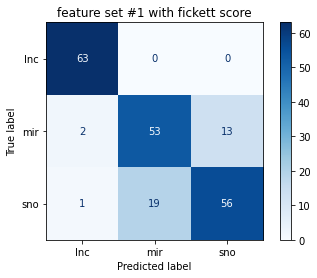

In [15]:
#classification matrix for the original model
print(classification_report(y_test, y_pred))

#path = "fs1/w_fickett/results"
#if not os.path.isdir(join(path)):
#    os.makedirs(join(path))
#plt.savefig(join(path,"feat_imp.png"))

disp = plot_confusion_matrix(rnd_clf, X_test, y_test,
                                     display_labels=["lnc","mir","sno"],
                                     cmap=plt.cm.Blues)
disp.ax_.set_title('feature set #1 with fickett score')
disp.confusion_matrix
#plt.savefig(join(path,"conf_mat.png"))

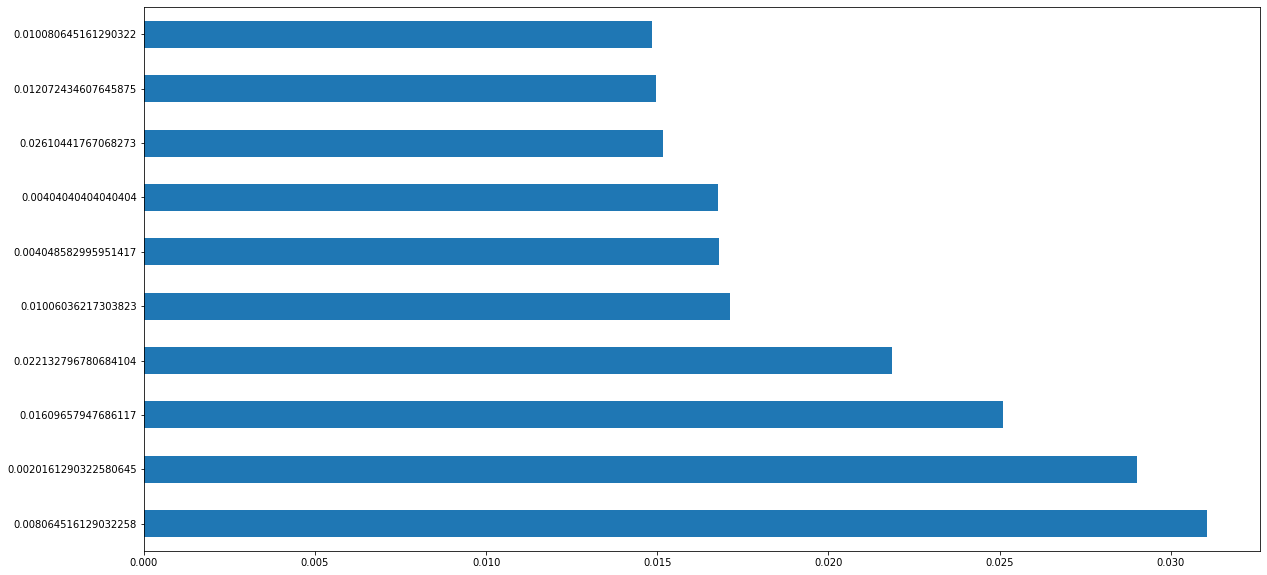

In [16]:
#feature importances
feat_imp = rnd_clf.feature_importances_
importances = pd.Series(feat_imp, index=features_combined.drop(["target"],1).columns)
importances.nlargest(10).plot(kind="barh",figsize=(20,10))

the next section follows the unsupervised learning setup.
k-means clustering of the three RNA classes and PCA with two components.

In [17]:
#k-means clustering of the three classes
y_test = np.ravel(y_test)

km = KMeans (n_clusters=3, init="k-means++", random_state=42).fit(X_train)

y = km.predict(X_test)

print (f'number of iterations : {km.n_iter_}\n')

#labels : {0: lnc, 1: mir, 2:sno}
#training set
print(f'predicted classes on the training set: {Counter(km.labels_)}\n')
print(f'actual classes on the trainig set: {Counter(y_train)}\n')
print(f'accuracy training set: {accuracy_score(y_train, km.labels_)}\n')
print(f'number of correctly classified samples: {accuracy_score(y_train, km.labels_, normalize=False)}\n')

#test set
print(f'predicted classes on the test set: {Counter(y)}\n')
print(f'actual classes on the test set: {Counter(y_test)}\n') 
print(f'accuracy test set: {accuracy_score(y_test, y)}')

number of iterations : 16

predicted classes on the training set: Counter({2: 278, 0: 278, 1: 272})

actual classes on the trainig set: Counter({0.0: 282, 1.0: 277, 2.0: 269})

accuracy training set: 0.3442028985507246

number of correctly classified samples: 285

predicted classes on the test set: Counter({2: 207})

actual classes on the test set: Counter({2.0: 76, 1.0: 68, 0.0: 63})

accuracy test set: 0.3671497584541063


explained variance ratio: [0.89200997 0.00130433]
n_compponents: 2
features: 7098
samples: 828


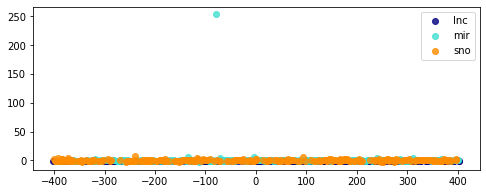

In [18]:
#pca
p = PCA(n_components=2, random_state=42)

X= p.fit_transform(X_train)

print(f'explained variance ratio: {p.explained_variance_ratio_}')
print(f'n_compponents: {p.n_components_}')
print(f'features: {p.n_features_}')
print(f'samples: {p.n_samples_}')

fig = plt.figure(figsize=(8,3))
colours = ['navy', 'turquoise', 'darkorange']
targets = ['lnc', 'mir', 'sno']
lw=2
for colour, i, target_name in zip(colours, [0, 1, 2], targets):
    plt.scatter(X[y_train == i, 0], X[y_train == i, 1], color=colour, alpha=.8, #lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)